# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2022/23 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari
---


## Lab. 03 - PyTorch regression and classification


In [76]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [77]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Practical example: Linear Regression

Now let's solve the same problem analyzed in one of the previous lab using a simple neural network implemented in PyTorch.


# Data generation

Let's generate some data with our usual polynomial model, and save the data points in two csv files, one for training (train_data.csv), and one for validation (val_data.csv).

You can find these files in the "Files" section of Colab. They are not stored in your local machine, but they are stored remotely in the Colab server.

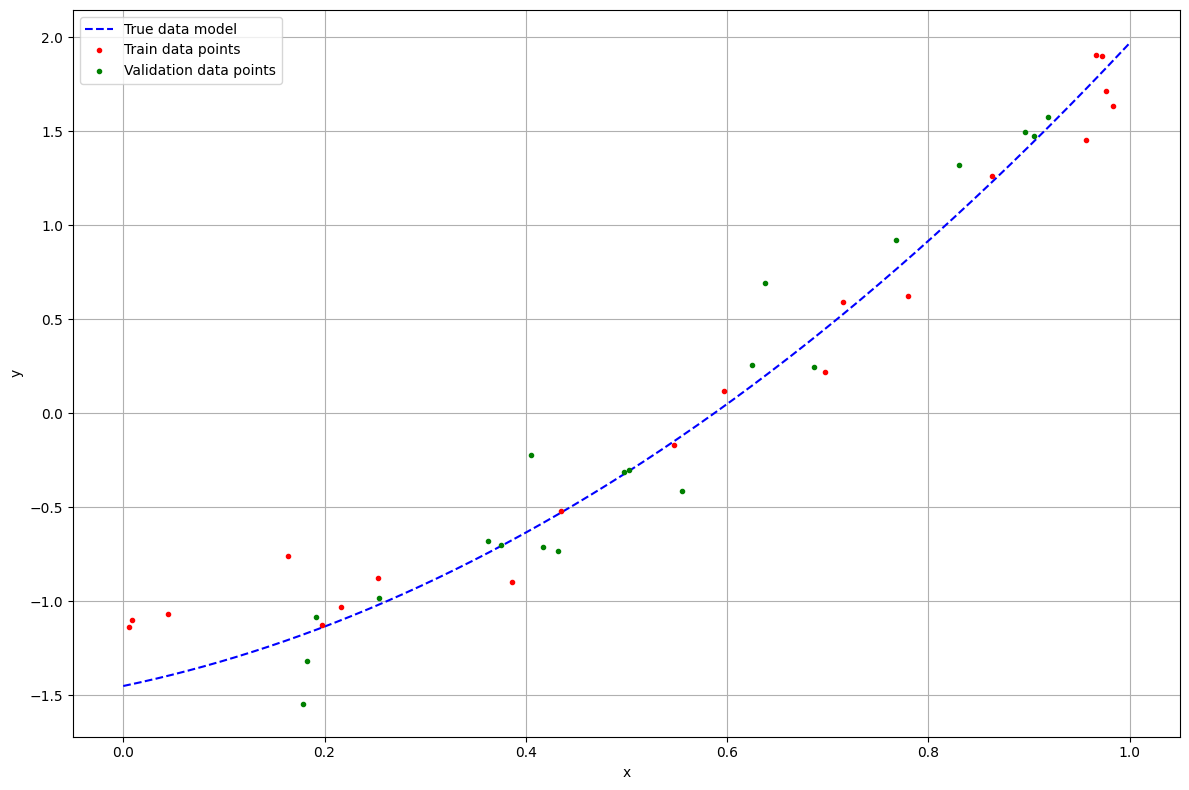

In [78]:
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

beta_true = [-1.45, 1.12, 2.3]
noise_std = 0.2
np.random.seed(4)

### Train data
num_train_points = 20
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))

### Validation data
num_val_points = 20
x_val = np.random.rand(num_val_points)
y_val = poly_model(x_val, beta_true, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))


### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Network Training

## Network Definition

Define a fully connected feed-forward network with 2 hidden layers.

Use a sigmoid activation function.

Since this is a regression, we do not want to limit the value of the output. For this reason, NO activation function should be used for the output layer.

In [79]:
class Net(nn.Module):

    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        ###################################################
        self.fc1 = nn.Linear(in_features = Ni, out_features = Nh1)
        self.fc2 = nn.Linear(in_features = Nh1, out_features = Nh2)
        self.out = nn.Linear(in_features = Nh2, out_features = No)
        self.act = nn.Sigmoid()
        ###################################################

    def forward(self, x, additional_out=False):
        ###################################################
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        ###################################################
        return x

## Dataset and Dataloader


We have already implemented the dataset class in the previous lab.

### Dataset

In [80]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### Transforms

In [81]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [82]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader

For the dataloader:

* enable the shuffling only for training data
* try different values for batch size
* disable the multiprocessing

In [83]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

## Training loop

Now we put together all the steps analyzed in the previous lab:

In [84]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [85]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

In [86]:
# Define the loss function
loss_fn = nn.MSELoss()

In [87]:
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [88]:
num_epochs = 3000
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        ###########################################
        ### PUT YOUR CODE HERE
        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()
        ###########################################

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            ###########################################
            ### PUT YOUR CODE HERE
            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)
            ###########################################

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)


        # Save average validation loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)


Output streaming troncato alle ultime 5000 righe.
#################
# EPOCH 2000
#################
AVERAGE TRAIN LOSS: 0.030761191621422768
AVERAGE VAL LOSS: 0.07925938814878464
#################
# EPOCH 2001
#################
AVERAGE TRAIN LOSS: 0.023854676634073257
AVERAGE VAL LOSS: 0.05682025104761124
#################
# EPOCH 2002
#################
AVERAGE TRAIN LOSS: 0.023417338728904724
AVERAGE VAL LOSS: 0.060226332396268845
#################
# EPOCH 2003
#################
AVERAGE TRAIN LOSS: 0.02044098451733589
AVERAGE VAL LOSS: 0.06732533872127533
#################
# EPOCH 2004
#################
AVERAGE TRAIN LOSS: 0.020265022292733192
AVERAGE VAL LOSS: 0.05813707783818245
#################
# EPOCH 2005
#################
AVERAGE TRAIN LOSS: 0.019765496253967285
AVERAGE VAL LOSS: 0.05999646335840225
#################
# EPOCH 2006
#################
AVERAGE TRAIN LOSS: 0.02011236920952797
AVERAGE VAL LOSS: 0.061442404985427856
#################
# EPOCH 2007
#################
AVERA

### Plot losses

Additional tool for visualization: tensorboard

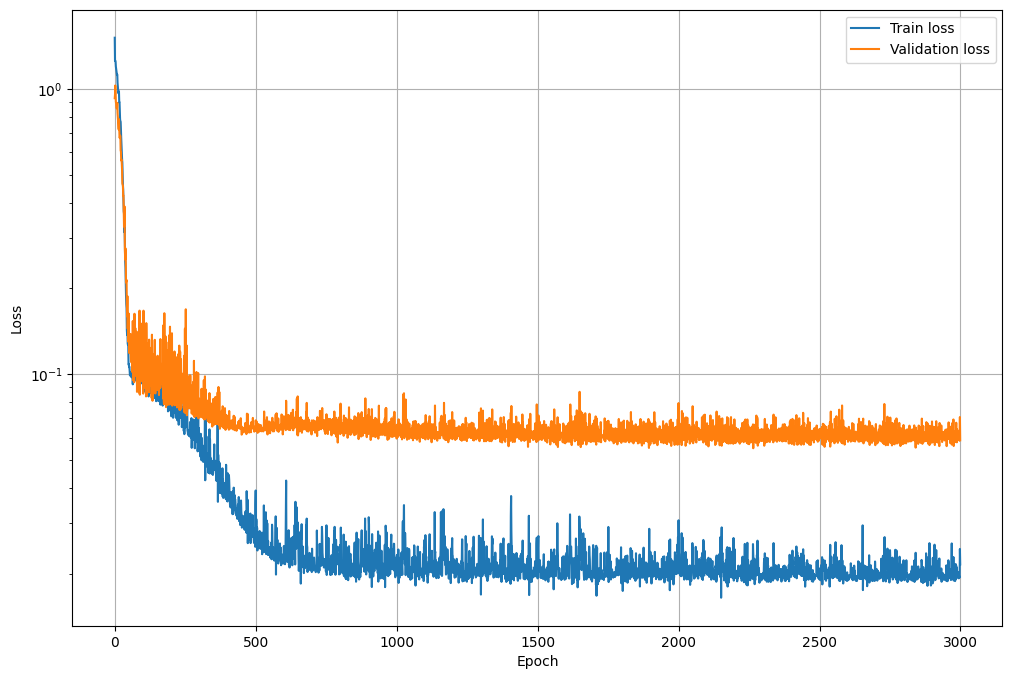

In [89]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Network analysis

## Network output

In [90]:
# Input vector
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout
# BatchNorm etc.
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


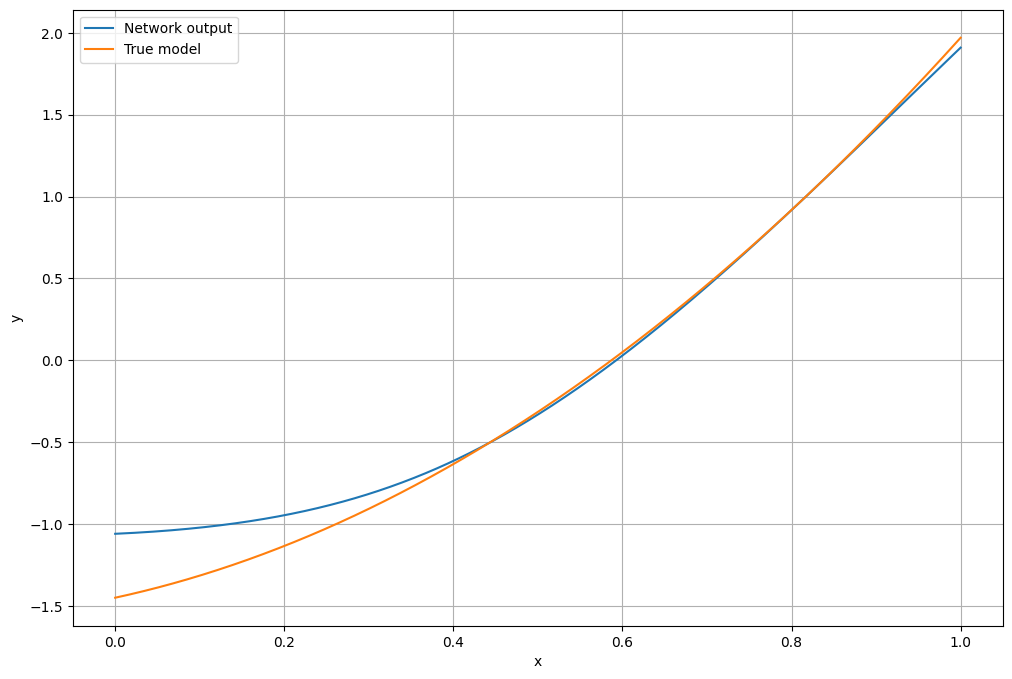

In [91]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

### What if we predict outside the range?

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


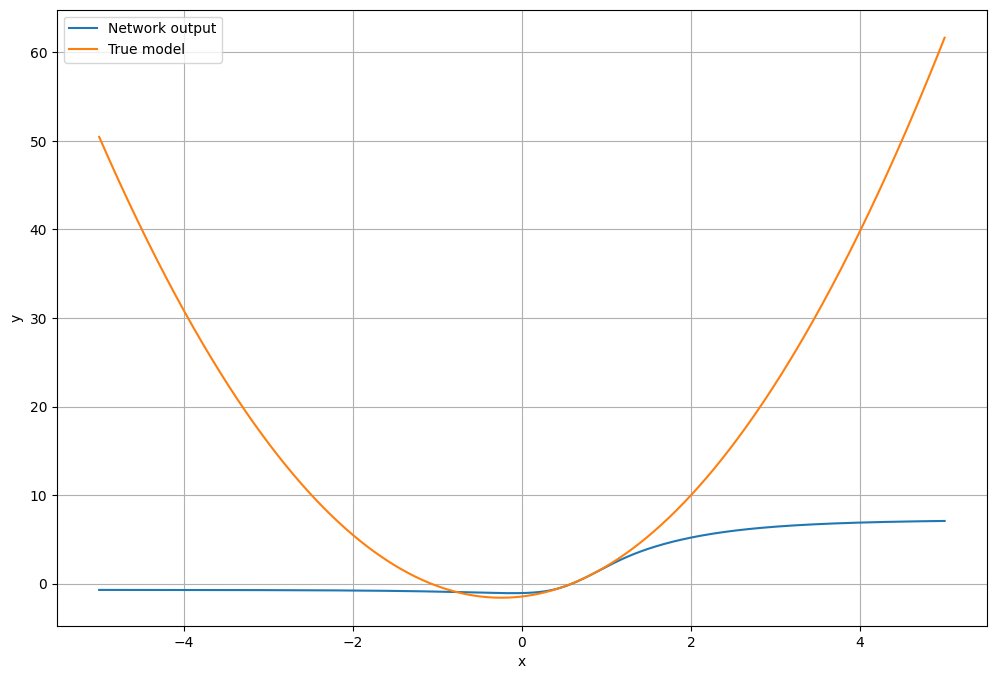

In [92]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
net.eval()
with torch.no_grad():
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

### What if we try different activation functions? (e.g., ReLU for nonlinearities)
### Is there overfit with ReLU?

### Homework : add some regularization to fight overfitting (e.g., dropout, weight decay,...)

## Access network parameters

In [93]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

## Weights histogram

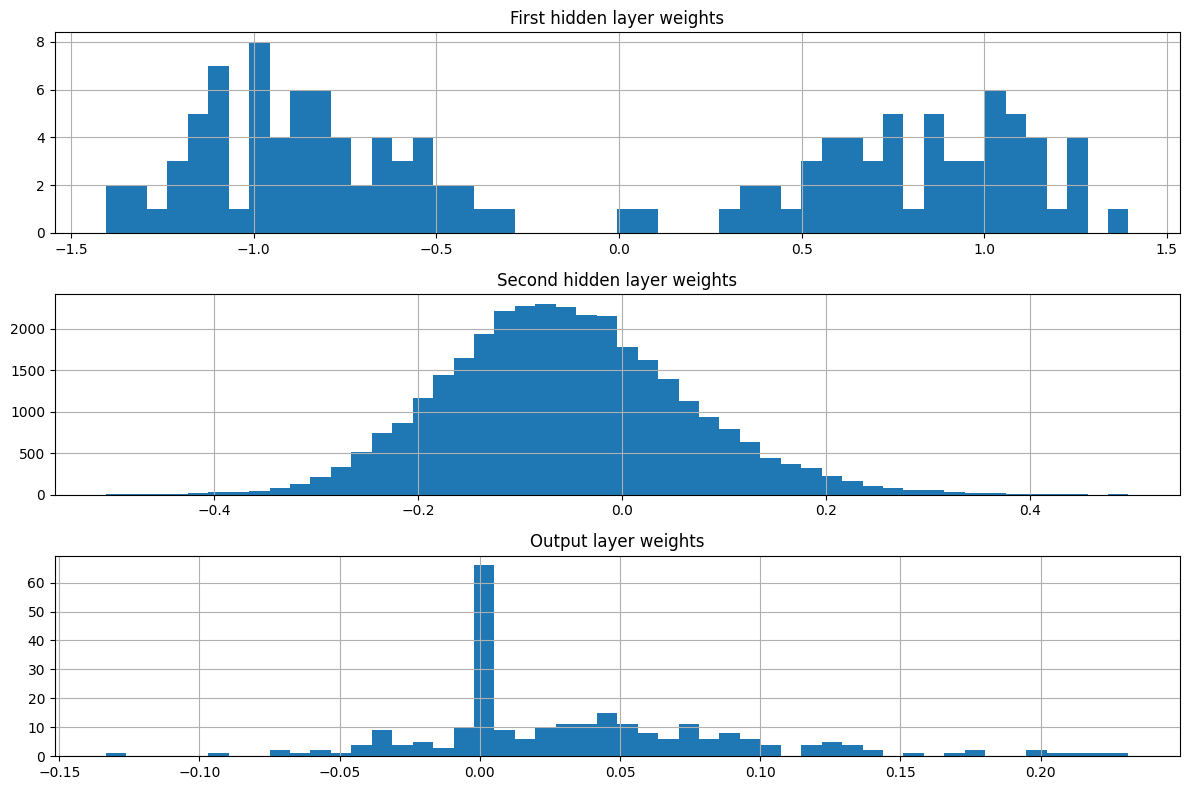

In [94]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

#### Homework (simple): compare the histogram before and after the training

## Save network parameters

### Save network

In [95]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])


### Load network

In [96]:
### Reload the network state
# First initialize the network (if not already done)
# IMPORTANT: you need to know the model definition!!
net = Net(Ni, Nh1, Nh2, No)
# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

## Save optimizer state
Also the optimizer has its internal state!

You need to save both the network and the optimizer states if you want to continue your training.

If you are sure you have finished your training you can just save the network.

In [97]:
### Save the optimizer state
torch.save(optimizer.state_dict(), 'optimizer_state.torch')

### Reload the optimizer state
optimizer = optim.Adam(net.parameters(), lr=0.001)
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)

## Analyze activations

<ipython-input-98-6284693a1181>:31: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
<ipython-input-98-6284693a1181>:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
<ipython-input-98-6284693a1181>:35: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[2].st

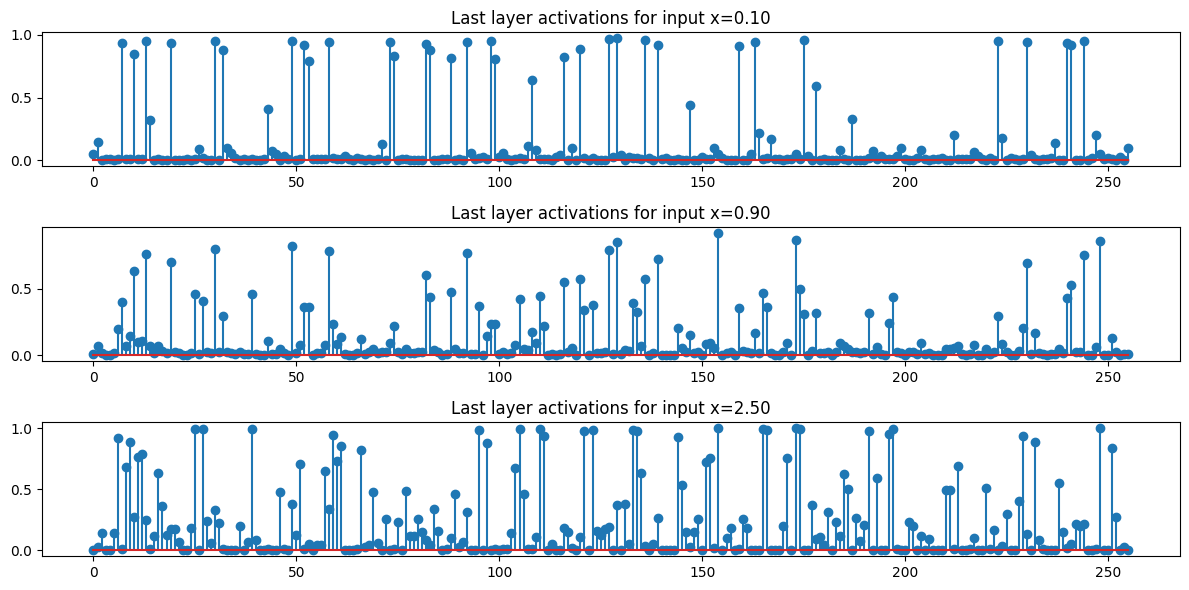

In [98]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy (optional if you're not familiar with Python!): using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Exercise - Classification model


**HINTS**
- Choose a loss function that is suitable for the specific problem, a binary classification in this case. If you keep a single linear output you can use a BCEWithLogitsLoss, which is more numerically stable than manually using a sigmoid output activation (more info here: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html ).
- The network now has 2 inputs. A batched input should have a shape $\text{batch_size} \times 2$.
- The dataset should be adapted accordingly. Also consider to increase the batch size.
- Explore different optimizers, trying to understand the differences and their parameters (https://pytorch.org/docs/stable/optim.html ).
- Try to increase the complexity of the network, and at the same time to introduce some regularization with dropout layers and/or weight decay (which is equivalent to an L2 regularization, typically implemented by the optimizer).
- Experiment with different hyper-parameters trying to minimize the VALIDATION LOSS. Once you are happy with the result, try the final test with the TEST dataset.

## Data generation

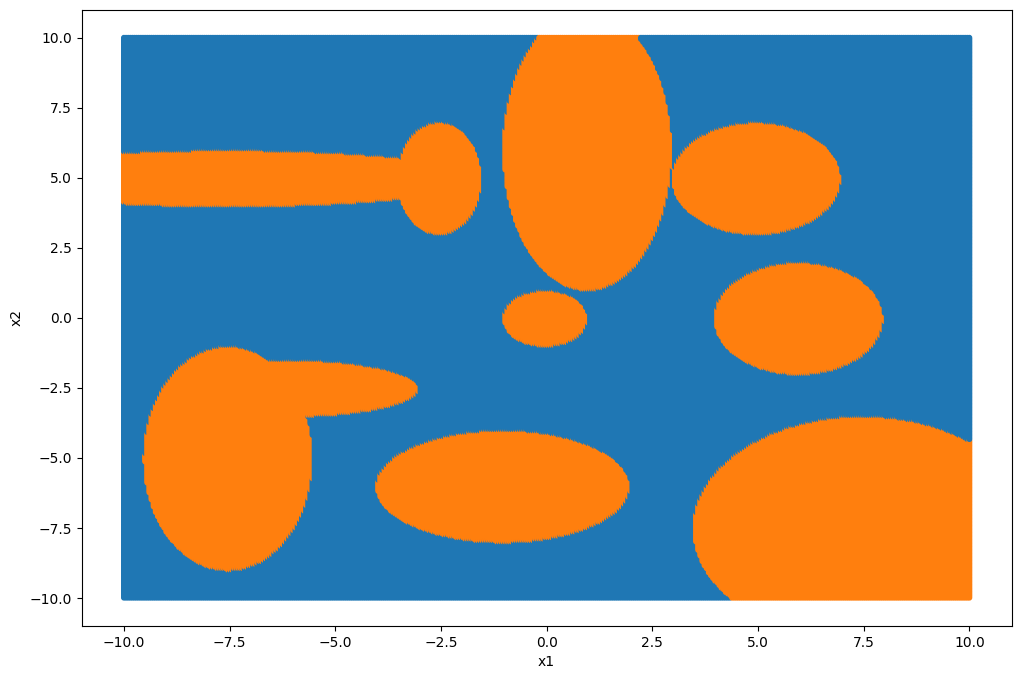

In [99]:
import itertools

np.random.seed(123)

def bidimensional_model(x1, x2):
    a = 1
    b = 1
    cx1 = 0
    cx2 = 0
    out = (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 1
    b = 2
    cx1 = -2.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 1
    cx1 = -6
    cx2 = -2.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 4
    cx1 = -7.5
    cx2 = -5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 6
    b = 1
    cx1 = -7.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 4
    b = 4
    cx1 = 7.5
    cx2 = -7.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 2
    cx1 = -1
    cx2 = -6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 5
    cx1 = 1
    cx2 = 6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 6
    cx2 = 0
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    return out.astype(int)

### PLOT MODEL
# Input grid
x1 = np.linspace(-10, 10, 400)
x2 = np.linspace(-10, 10, 400)
x_prod = [x for x in itertools.product(x1, x2)]
x1 = np.array([x[0] for x in x_prod])
x2 = np.array([x[1] for x in x_prod])
# Evaluate out
y = bidimensional_model(x1, x2)
# Scatter plot
fig, ax = plt.subplots(figsize=(12,8))
colors = np.array(['C0', 'C1'])
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.show()

### Training points

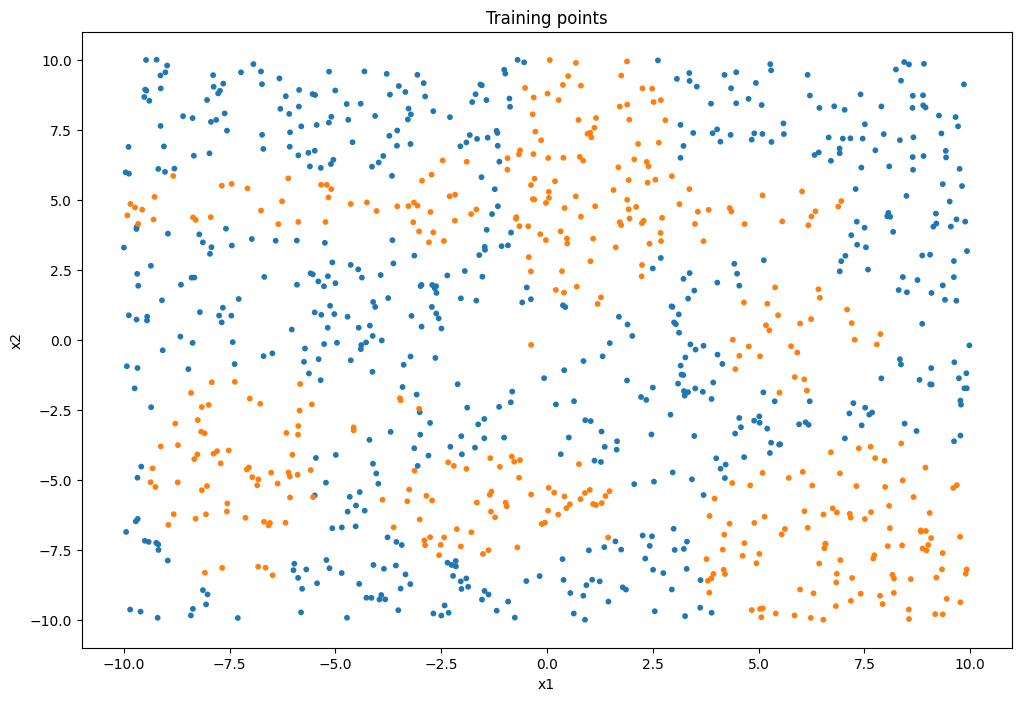

In [100]:
import pandas as pd

### Train data
num_points = 1000
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
train_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
train_df.to_csv('classifier_train_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Training points')
fig.show()

### Validation points

In this case: we generate validation points.
Usually: validation points are randomly selected from the training points (~20% of training data).

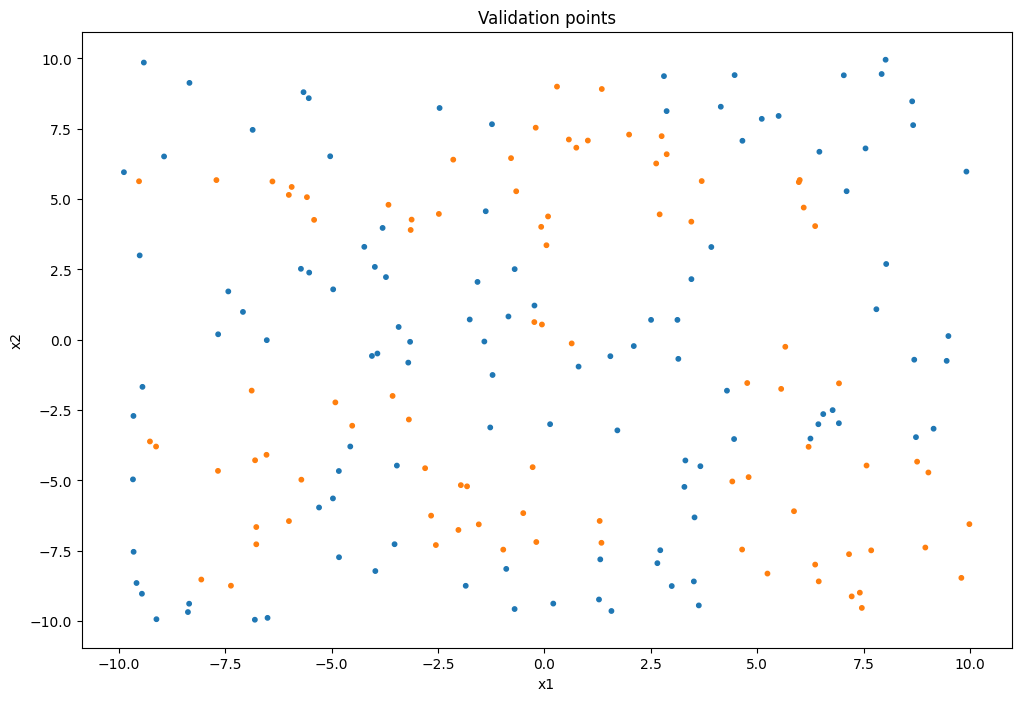

In [101]:
### Validation data
num_points = 200
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_val_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Validation points')
fig.show()

### Test points

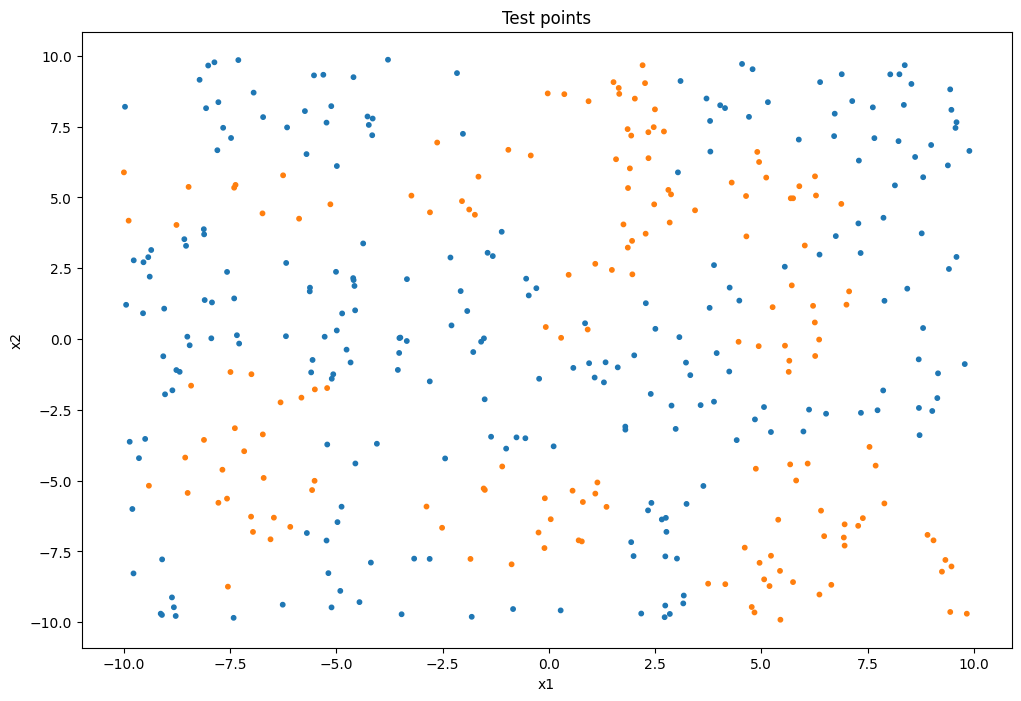

In [102]:
### Test data
num_points = 400
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_test_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Test points')
fig.show()

## Dataset and Dataloader

Define the dataset

In [103]:
class ClassifierDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        ###############################
        self.transform = transform
        # Read the file and store the content in a pandas DataFrame
        self.df = pd.read_csv(csv_file)
        ###############################

    def __len__(self):
        ###############################
        # The length of the dataset is simply the length of the self.data list
        return len(self.df)
        ###############################

    def __getitem__(self, idx):
        # Our sample is the row at index idx of the dataframe

        ###############################
        row = self.df.iloc[idx]
        # There are 2 inputs this time
        sample = ([row.x1, row.x2], row.y)
        if self.transform:
            sample = self.transform(sample)
        ###############################
        return sample

Define the transformations

In [110]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor(x).float(),
                torch.Tensor([y]).float())

Initialize the datasets

In [111]:
###############################
composed_transform = transforms.Compose([ToTensor()])

train_dataset = ClassifierDataset('classifier_train_data.csv', transform = composed_transform)
val_dataset   = ClassifierDataset('classifier_val_data.csv', transform = composed_transform)
test_dataset  = ClassifierDataset('classifier_test_data.csv', transform = composed_transform)
###############################

Define the dataloaders

In [112]:
###############################
#Put your code here
train_dataloader = DataLoader(train_dataset, batch_size = 200, shuffle = True, num_workers = 0) #batch size = 200
val_dataloader   = DataLoader(val_dataset, batch_size = len(val_dataset), shuffle = False, num_workers = 0) #The batch size can be equal to the validation set size if it fits in memory
test_dataloader  = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False, num_workers =0)
###############################

## Network definition

In [113]:
class Net(nn.Module):

    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()

    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

## Training loop

In [114]:
# Initialize the network
torch.manual_seed(0)
Ni = 2
Nh1 = 128
Nh2 = 256
No = 1 #now we have classification between two classes

net = Net(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
###############################################
loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer with lr=1e-2
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
###############################################

Network initialized


In [115]:
### TRAINING LOOP
num_epochs = 600
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    ###############################################
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)
        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
        ###############################################
        # Save average validation loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)


#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.8219033479690552
AVERAGE VAL LOSS: 0.7205468416213989
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.6980244517326355
AVERAGE VAL LOSS: 0.7325747609138489
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.6665133237838745
AVERAGE VAL LOSS: 0.6907755732536316
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.6568112969398499
AVERAGE VAL LOSS: 0.680313766002655
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.6458554863929749
AVERAGE VAL LOSS: 0.6874321699142456
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.6376011967658997
AVERAGE VAL LOSS: 0.6707899570465088
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.6298103332519531
AVERAGE VAL LOSS: 0.6671848297119141
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.6176234483718872
AVERAGE VAL LOSS: 0.6677796840667725
#################
# EPOCH

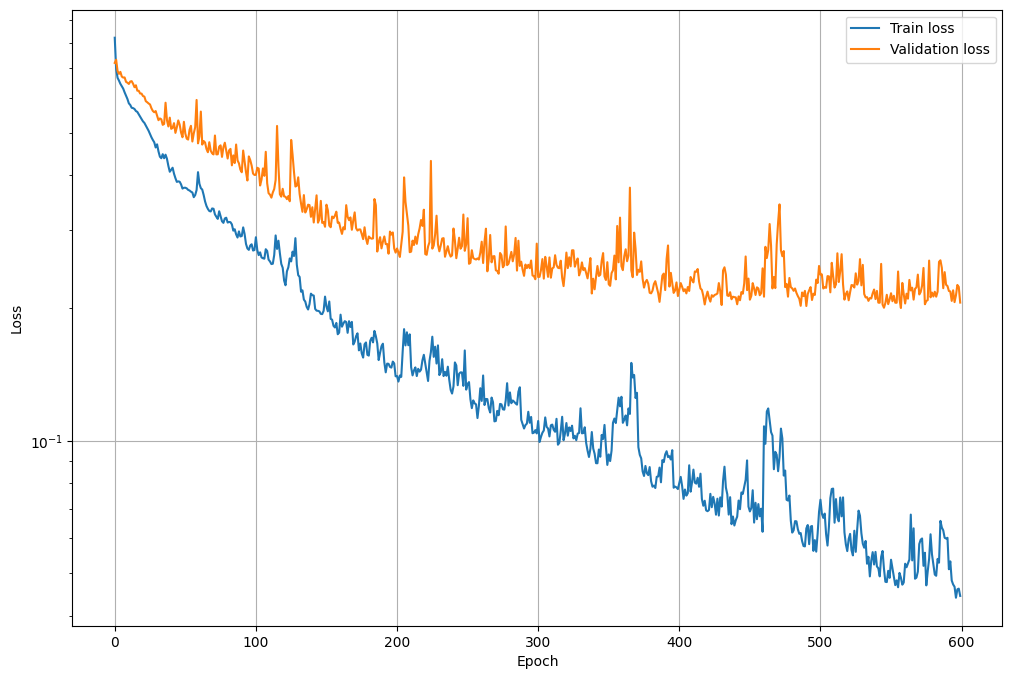

In [116]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Final test

Iterate the dataloader a single time and save all the outputs (in case you have multiple batches)

In [117]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.2096303552389145


In this case the network has a linear output (for a better stability of the loss function).
To have probability estimates you can apply a sigmoid to the network output.

Since we just need the most probable class and we have a single output, we can consider the sign of the linear output. Negative output means that the class 0 is the most probable (probability < 50%), otherwise class 1 (probability > 50%).

Essentially this network estimates the probability of the input sample to be of class 1.

> **NOTE**
>
> You can (and should, for practice) redefine the problem by defining a network with more than one output, each of them corresponding to a specific class (2 in this case). Since the two classes are mutually exclusive, the loss function should be a CrossEntropyLoss (softmax activation). In a multi-class scenario, a BCE loss is suitable when the classes are NOT mutually exclusive.






---


Get the most probable class inferred by the network


In [119]:
# Get the most probable class inferred by the network
all_output_classes = torch.zeros(all_outputs.shape).to(device)
all_output_classes[all_outputs > 0] = 1

Evaluate the test accuracy

In [120]:
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 93.50%


Plot the results

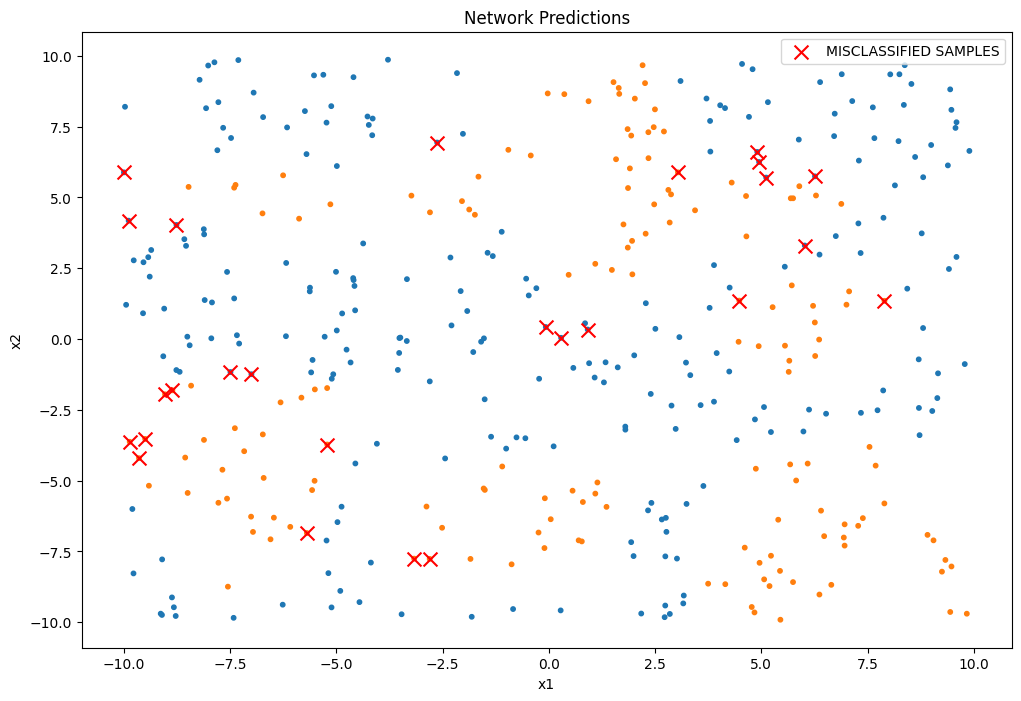

In [121]:
### Plot
x1 = all_inputs.squeeze().cpu().numpy()[:, 0]
x2 = all_inputs.squeeze().cpu().numpy()[:, 1]
y_true = all_labels.squeeze().cpu().numpy()
y_pred = all_output_classes.squeeze().cpu().numpy()

fig, ax = plt.subplots(figsize=(12,8))
# Plot predictions
ax.scatter(x1, x2, c=colors[y_pred.astype(np.uint8)], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Network Predictions')
# Mark wrong outputs
error_mask = y_pred != y_true
ax.scatter(x1[error_mask], x2[error_mask], color='red', s=100, marker='x', label='MISCLASSIFIED SAMPLES')
plt.legend()
fig.show()

# (Optional) High-level and Lightweight PyTorch wrapper: PyTorch Lightning


Lightning forces the following structure to your code which makes it reusable and shareable:

Research code (the LightningModule).
Engineering code (you delete, and is handled by the Trainer).
Non-essential research code (logging, etc... this goes in Callbacks).
Data (use PyTorch DataLoaders or organize them into a LightningDataModule).
Once you do this, you can train on multiple-GPUs, TPUs, CPUs and even in 16-bit precision without changing your code!

In [126]:
! pip install pytorch-lightning

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [127]:
# Define a LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).
class LitNet(pl.LightningModule):
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        self.net = nn.Sequential(nn.Linear(in_features=Ni, out_features=Nh1),
                       nn.Sigmoid(),
                       nn.Linear(in_features=Nh1, out_features=Nh2),
                       nn.Sigmoid(),
                       nn.Linear(in_features=Nh2, out_features=No))
        self.val_loss = []
        self.train_loss = []

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.net(x)

    # Training_step defines the training loop.
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.binary_cross_entropy_with_logits(out, label_batch)
        self.train_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx=None):
        # validation_step defines the validation loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.binary_cross_entropy_with_logits(out, label_batch)
        self.val_loss.append(loss.item())
        self.log("val_loss", loss.item(), prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(), lr=1e-2)
        return optimizer

In [128]:
# TRAIN!
batch_size = 200
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

trainer = pl.Trainer(gpus=1, max_epochs=20, val_check_interval=1)
litnet = LitNet(Ni, Nh1, Nh2, No)
trainer.fit(litnet, train_dataloader, val_dataloader)


TypeError: ignored

In [129]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(litnet.train_loss, label='Train loss')
plt.semilogy(litnet.val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

NameError: ignored

<Figure size 1200x800 with 0 Axes>

# (Optional) Automatic Hyper-parameters Tuning: Optuna


Optuna is an automatic hyperparameter optimization software framework.

- Lightweight, versatile, and platform agnostic architecture
- Pythonic search spaces
- Efficient optimization algorithms
- Easy parallelization
- Quick visualization


Definitions:

- Study: optimization based on an objective function
- Trial: a single execution of the objective function

The goal of a study is to find out the optimal set of hyperparameter values (e.g., classifier and svm_c) through multiple trials (e.g., n_trials=100). Optuna is a framework designed for the automation and the acceleration of the optimization studies.

Optuna works with PyTorch, but also with Tensorflow, Keras and PyTorch Lightning! (and many others)

In [130]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.1 MB/s eta 0:00:00


In [131]:
# Before we used:
# Nh1 = 128
# Nh2 = 256

import optuna

def objective(trial):

    # We optimize the number of hidden units in each layer.
    output_dims = [
        trial.suggest_int("n_units_l{}".format(i), 64, 256, log=True) for i in range(2)
    ]

    model = LitNet(Ni, output_dims[0], output_dims[1], No)

    trainer = pl.Trainer(gpus=1, max_epochs=20, val_check_interval=1,
                         log_every_n_steps=1)
    hyperparameters = dict(output_dims=output_dims)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, train_dataloader, val_dataloader)
    return trainer.callback_metrics["val_loss"].item()


pruner = optuna.pruners.NopPruner()
# print(pruner) <optuna.pruners._nop.NopPruner object at 0x7f4c2466ed50>
# print(type(pruner)) <class 'optuna.pruners._nop.NopPruner'>

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=3, timeout=300)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-30 18:27:56,948] A new study created in memory with name: myfirstoptimizationstudy
[W 2023-10-30 18:27:56,955] Trial 0 failed with parameters: {'n_units_l0': 198, 'n_units_l1': 218} because of the following error: TypeError("Trainer.__init__() got an unexpected keyword argument 'gpus'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-131-cc04d8901694>", line 16, in objective
    trainer = pl.Trainer(gpus=1, max_epochs=20, val_check_interval=1,
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/argparse.py", line 70, in insert_env_defaults
    return fn(self, **kwargs)
TypeError: Trainer.__init__() got an unexpected keyword argument 'gpus'
[W 2023-10-30 18:27:56,956] Trial 0 failed with value None.


Network initialized


TypeError: ignored

# Homework

Try tuning other hyper-parameters, such as the learning rate.